# Environment setting

In [1]:
import numpy as np
from scipy import spatial
import matplotlib
import matplotlib.animation as animation
import time
from tqdm.auto import tqdm
import torch
import pickle

import math
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.style.use("seaborn")

# Main set-up

In [3]:
space_size = 1
starting_point = np.array([0,0])
ending_point = np.array([1,1])

In [4]:
obstacle_shape = "circle"
obstacle_size = 0.1 # radius of circle
obstacle_number = 5

In [5]:
def obstacle_generator(number=obstacle_number,size=obstacle_size, seed=0):
    np.random.seed(seed)
    center = np.random.rand(number,2)*(1-size*2)+size
    return center  

# Build simulator

In [6]:
class Simulator:
    def __init__(self, starting_point, ending_point, center, shape="circle"):
        self.starting_point = starting_point  # robot's initial position
        self.ending_point = ending_point  # destination
        self.center = center  # a list of obstacle centers
        # size of obstacle (diameter for circles and side length for squares)
        self.obstacle_size = 0.1
        self.shape = shape  # shape of obstacles
    def collision_detect(self, p_rand2, p_rand1):
        '''
            AUXILIARY

            input: coordinates of the two points (p_rand1 and p_rand2)

            function: detect if any point in the line segment between p_rand1 and p_rand2 is
            inside any obstacle

            output: Bool value. True for at least one collision. False for no collision.
        '''
        p_rand1 = np.array(p_rand1)  # transform the data type
        p_rand2 = np.array(p_rand2)

        if self.shape == "circle":  # the chosen obstacle shape is circle
            for i in self.center:  # iterate through every obstacle
                # collision mode 1: check if p_rand1 or p_rand2 is inside any obstacle
                if np.linalg.norm(p_rand1-i) <= self.obstacle_size or np.linalg.norm(p_rand2-i)\
                        <= self.obstacle_size:
                    return True
                # collision mode 2: check other points in line segment
                alpha, distance = self.distance_point2points(
                    p_rand1, p_rand2, i)
                # Obstacle's center is point O. Draw a line of p_rand1 and p_rand2,
                # and find a point p_3 in the line, with which line p_3-O ⊥ p_rand1-p_rand2.
                # Then, alpha = vector(p_3,p_rand1)/vector(p_rand2,p_rand1),
                # and distance = ||p_3-O||.
                if alpha > 0 and alpha < 1 and distance < self.obstacle_size:
                    # only when alpha ∈ (0,1) and p_3 is inside any obstacle, there's a collision.
                    return True
            return False  # failed to find a collision
        
        elif self.shape == "square":# the chosen obstacle shape is square
            size = self.obstacle_size
            for i in self.center:
                corner1 = i + np.array([size/2,size/2])
                corner2 = i + np.array([-size/2,size/2])
                corner3 = i + np.array([-size/2,-size/2])
                corner4 = i + np.array([size/2,-size/2])
                corner_pair = [(corner1,corner2),(corner2,corner3),(corner3,corner4),(corner4,corner1)]
                corners = [corner1,corner2,corner3,corner4,corner1] # clockwise
                for (c1,c2) in corner_pair:
                    if self.cross_or_not(p_rand1,p_rand2,c1,c2):
                        return True
                if self.inside_polygon_or_not(p_rand1,corners) or \
                   self.inside_polygon_or_not(p_rand2,corners):
                    return True
            return False

    def end_or_not(self, point):
        '''
            AUXILIARY

            input: a point

            function: judge if this point can be regarded as a destination.

            output: Bool value. True for yes, and False for no.
        '''
        if np.linalg.norm(point-self.ending_point) < self.step_size and \
                self.collision_detect(self.ending_point, point) == False\
                and self.angle_too_large(point, self.ending_point) == False:
            # Three conditions should be satisfies in the meantime:
            # Condition 1: close enough to ending point
            # Condition 2: no obstacle between current point and destination
            # Condition 3: the action from current point to destination satisfies the velocity
            # angle constraint. eg (-60,+60)
            return True
        else:
            return False

    def inside_region(self, p_new):
        '''
            AUXILIARY

            input: a point

            function: judge if this point is inside our environment or not.
                      Here, our environment is a square region, from (0,0) to (1,1)

            output: Bool value. True for yes, and False for no.
        '''
        return p_new[0] >= 0 and p_new[0] <= 1 and p_new[1] >= 0 and p_new[1] <= 1

    def distance_point2points(self, p1, p2, p3):
        '''
            AUXILIARY

            input: three points. p1 and p2 are points in RRT, p3 is the center of an obstacle.

            function: calculate the distance from p3 to line p1-p2, also see if the closest point
                      (p4) in line p1-p2 to p3 is inside line segment p1-p2 or not.

            output: the position of p4 and the distance between p3 and p4
        '''
        alpha = np.dot((p3-p1), (p2-p1))/(np.linalg.norm(p2-p1)**2)
        distance = np.linalg.norm(np.cross(p2-p1, p1-p3))/(np.linalg.norm(p2-p1)**2)
        return alpha, distance
    
    def to_categorical(self, y):
        '''
            AUXILIARY
            
            input: an angle in radian system
            
            output: transform the continuous values of angle into discretized classes.
        '''
        if (y <= np.pi/3 and y > np.pi*5/18):
            yy = int(0)
        elif (y <= np.pi*5/18 and y > np.pi/6):
            yy = int(1)
        elif (y <= np.pi/6 and y > np.pi/18):
            yy = int(2)
        elif (y <= np.pi/18 and y > -np.pi/18):
            yy = int(3)
        elif (y <= -np.pi/18 and y > -np.pi/6):
            yy = int(4)
        elif (y <= -np.pi/6 and y > -np.pi*5/18):
            yy = int(5)
        elif (y <= -np.pi*5/18):
            yy = int(6)
        else:
            print("out of range!")
        return yy
    
    def observe_148(self, point, face_direction,j):  # for neural network input
        observation_camera = self.observe_with_camera(point, face_direction)
        observation_lidar = self.observe_with_lidar(point, face_direction)
        observation_gps = self.observe_with_gps(point, face_direction)
        input1 = np.hstack(
            (observation_camera, observation_lidar,observation_gps)).reshape([-1, 3, 72])
        input2 = (face_direction).reshape([-1, 2])
        return input1, input2
    
    def observe_with_camera(self, p1, face_direction=np.array([1, 0]), num=72):
        '''
            AUXILIARY
            
            input: a point p1, the current heading direction, and the number of sensor data 
                   after scanning 360°
                   
            function: use a camera to scan 360°
            
            output: a np array of camera data, shape=(1,num). 1 for obstacle, and 0 for wall.
        '''
        obstacle_size = self.obstacle_size
        observation = np.zeros(num)
        # 72*5 = 360
        if self.shape == "circle":
            for i, angle in enumerate(np.linspace(0, 2*np.pi, num+1)[:-1]):
                p2 = p1 + np.array([np.cos(angle)*face_direction[0]-np.sin(angle)*face_direction[1],
                                    np.sin(angle)*face_direction[0]+np.cos(angle)*face_direction[1]])
                for p3 in self.center:
                    alpha, distance = self.distance_point2points(p1, p2, p3)
                    if distance < obstacle_size and alpha > 0:
                        observation[i] = 1
                        break
        elif self.shape == "square":
            size = self.obstacle_size
            for i, angle in enumerate(np.linspace(0, 2*np.pi, num+1)[:-1]):
                p2 = p1 + np.array([np.cos(angle)*face_direction[0]-np.sin(angle)*face_direction[1],
                                    np.sin(angle)*face_direction[0]+np.cos(angle)*face_direction[1]])
                for c in self.center:
                    corner1 = c + np.array([size/2,size/2])
                    corner2 = c + np.array([-size/2,size/2])
                    corner3 = c + np.array([-size/2,-size/2])
                    corner4 = c + np.array([size/2,-size/2])
                    corner_pair = [(corner1,corner2),(corner2,corner3),(corner3,corner4),(corner4,corner1)]
                    for (c1,c2) in corner_pair:
                        if self.cross_or_not(p1,p2,c1,c2,mode="camera"):
                            observation[i] = 1
                            break
        return observation  # a list of 0 or 1, 1 for occupied, 0 for boundary

    def observe_with_gps(self, p1, face_direction=np.array([1, 0]), num=72):
        '''
            AUXILIARY
            
            input: a point p1, the current heading direction, and the number of sensor data 
                   after scanning 360°
                   
            function: use a gps to scan 360°
            
            output: a np array of gps data, shape=(1,num). value is the distance from current point
                    to starting point and ending point
        '''
        observation = np.zeros(num)
        critical_size = 0.1
        for i, angle in enumerate(np.linspace(0, 2*np.pi, num+1)[:-1]):
            p2 = p1 + np.array([np.cos(angle)*face_direction[0]-np.sin(angle)*face_direction[1],
                                np.sin(angle)*face_direction[0]+np.cos(angle)*face_direction[1]])
            p3 = self.starting_point
            alpha, distance = self.distance_point2points(p1, p2, p3)
            if distance < critical_size and alpha > 0:
                observation[i] = np.linalg.norm(p1-self.starting_point)
                continue
            p4 = self.ending_point
            alpha, distance = self.distance_point2points(p1, p2, p4)
            if distance < critical_size and alpha > 0:
                observation[i] = -np.linalg.norm(p1-self.ending_point)
        return observation

    def observe_with_lidar(self, p1, face_direction=np.array([1, 0]), num=72, plot=False):
        '''
            AUXILIARY
            
            input: a point p1, the current heading direction, the number of sensor data 
                   after scanning 360°, and a Bool value for visualization option.
                   
            function: use a lidar to scan 360°
            
            output: a np array of lidar data, shape=(1,num). value is the distance from current point
                    to the the closest object in each laser scanning direction.
        '''
        obstacle_size = self.obstacle_size
        observation = np.zeros(num)
        # split the directions into 4 regions, because there're 4 corners in environment
        angle_critical = []

        # first step, calculate the four critical angles related to 4 courers
        if (p1 != np.array([1, 1])).any():
            angle_critical.append(
                np.arccos((1-p1[0])/np.linalg.norm(np.array([1, 1])-p1)))
        else:
            angle_critical.append(1*np.pi/4)
        if (p1 != np.array([0, 1])).any():
            angle_critical.append(
                np.arccos((-p1[0])/np.linalg.norm(np.array([0, 1])-p1)))
        else:
            angle_critical.append(3*np.pi/4)
        if (p1 != np.array([0, 0])).any():
            angle_critical.append(
                np.pi+np.arccos((p1[0])/np.linalg.norm(np.array([0, 0])-p1)))
        else:
            angle_critical.append(5*np.pi/4)
        if (p1 != np.array([1, 0])).any():
            angle_critical.append(
                np.pi*2-np.arccos((1-p1[0])/np.linalg.norm(np.array([1, 0])-p1)))
        else:
            angle_critical.append(7*np.pi/4)                   
                    
        if self.shape == "circle":
            # second step, initialize the observation with the wall (max distance values)
            for i, angle in enumerate(np.linspace(0, 2*np.pi, num+1)[:-1]):
                angle = self.angle_combination(angle, face_direction)
                e_angle = np.array([np.cos(angle), np.sin(angle)])
                if angle >= angle_critical[0] and angle < angle_critical[1]:
                    observation[i] = (1-p1[1])/np.sin(angle)
                elif angle >= angle_critical[1] and angle < angle_critical[2]:
                    observation[i] = -p1[0]/np.cos(angle)
                elif angle >= angle_critical[2] and angle < angle_critical[3]:
                    observation[i] = -p1[1]/np.sin(angle)
                else:
                    observation[i] = (1-p1[0])/np.cos(angle)
                p2 = p1 + e_angle
                # third step, any obstacle exists in the direction, update the value of observation
                # with the smallest distance from current point to the objects in that direction.
                for p3 in self.center:
                    alpha, distance = self.distance_point2points(p1, p2, p3)
                    if alpha > 0 and distance < obstacle_size:
                        p4 = p1 + e_angle*alpha
                        distance_34 = np.linalg.norm(p4-p3)
                        distance_45 = np.sqrt(obstacle_size**2 - distance_34**2)
                        p5 = p4 - distance_45*e_angle
                        observation[i] = min(np.linalg.norm(p5-p1), observation[i])
        elif self.shape == "square":
            size = self.obstacle_size
            for i, angle in enumerate(np.linspace(0, 2*np.pi, num+1)[:-1]):
                angle = self.angle_combination(angle, face_direction)
                e_angle = np.array([np.cos(angle), np.sin(angle)])
                if angle >= angle_critical[0] and angle < angle_critical[1]:
                    observation[i] = (1-p1[1])/np.sin(angle)
                elif angle >= angle_critical[1] and angle < angle_critical[2]:
                    observation[i] = -p1[0]/np.cos(angle)
                elif angle >= angle_critical[2] and angle < angle_critical[3]:
                    observation[i] = -p1[1]/np.sin(angle)
                else:
                    observation[i] = (1-p1[0])/np.cos(angle)
                p2 = p1 + e_angle
                for c in self.center:
                    corner1 = c + np.array([size/2,size/2])
                    corner2 = c + np.array([-size/2,size/2])
                    corner3 = c + np.array([-size/2,-size/2])
                    corner4 = c + np.array([size/2,-size/2])
                    corner_pair = [(corner1,corner2),(corner2,corner3),(corner3,corner4),(corner4,corner1)]
                    for (c1,c2) in corner_pair:
                        distance,flag = self.cross_or_not(p1,p2,c1,c2,mode="lidar")
                        if flag == True:
                            observation[i] = min(distance,observation[i])
        if plot == True:
            self.plot_lidar(p1, num, observation, face_direction)
        return observation

    def plot_lidar(self, p1, num, observation, face_direction,ax=None):
        '''
            AUXILIARY
            
            input: a point p1, the current heading direction, the number of sensor data 
                   after scanning 360°.
                   
            function: visualize the observation data from the lidar
            
            output: no output.
        '''
        if ax == None:
            fig, ax = plt.subplots(figsize=(6, 6))
            plt.xlim(-0.1, 1.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(self.starting_point[0], self.starting_point[1], c="r")
            plt.scatter(self.ending_point[0], self.ending_point[1], c="b")
            if self.shape == "circle":
                for i in self.center:
                    # obstacle_size=0.1 by default
                    ax.add_artist(plt.Circle((i[0], i[1]), self.obstacle_size, color="g"))
            elif self.shape == "square":
                size = self.obstacle_size
                for i in self.center:
                    ax.add_artist(matplotlib.patches.Rectangle(i-np.array([size/2,size/2]),size,size, color='g'))
            plt.scatter(p1[0], p1[1], s=15, c="k", zorder=10)
            for i, angle in enumerate(np.linspace(0, 2*np.pi, num+1)[:-1]):
                if observation[i] != 0:
                    e_angle = np.array([np.cos(angle)*face_direction[0]-np.sin(angle)*face_direction[1],
                                        np.sin(angle)*face_direction[0]+np.cos(angle)*face_direction[1]])
                    p2 = p1 + e_angle*observation[i]
                    plt.scatter(p2[0], p2[1], s=15, c="k", zorder=10)
                    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], c="m", linewidth=1)
            plt.show()
        else:
            ax.set_xlim(-0.1, 1.1)
            ax.set_ylim(-0.1, 1.1)
            ax.scatter(self.starting_point[0], self.starting_point[1], c="r")
            ax.scatter(self.ending_point[0], self.ending_point[1], c="b")
            if self.shape == "circle":
                for i in self.center:
                    # obstacle_size=0.1 by default
                    ax.add_artist(plt.Circle((i[0], i[1]), self.obstacle_size, color="g"))
            elif self.shape == "square":
                size = self.obstacle_size
                for i in self.center:
                    ax.add_artist(matplotlib.patches.Rectangle(i-np.array([size/2,size/2]),size,size, color='g'))
            ax.scatter(p1[0], p1[1], s=15, c="k", zorder=10)
            for i, angle in enumerate(np.linspace(0, 2*np.pi, num+1)[:-1]):
                if observation[i] != 0:
                    e_angle = np.array([np.cos(angle)*face_direction[0]-np.sin(angle)*face_direction[1],
                                        np.sin(angle)*face_direction[0]+np.cos(angle)*face_direction[1]])
                    p2 = p1 + e_angle*observation[i]
                    ax.scatter(p2[0], p2[1], s=15, c="k", zorder=10)
                    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], c="m", linewidth=1)

    def angle_combination(self, angle, face_direction):
        '''
            AUXILIARY
            
            input: an angle, and the current heading direction
                   
            function: combine the angle with an radian value and the direction vector, and
                      transform the coordinate of the angle from Euler to Lagrange
            
            output: the angle value in Lagrange coordinate
        '''
        new_cos = np.cos(angle) * \
            face_direction[0]-np.sin(angle)*face_direction[1]
        new_sin = np.sin(angle) * \
            face_direction[0]+np.cos(angle)*face_direction[1]
        new_arccos = np.arccos(new_cos)
        new_arcsin = np.arcsin(new_sin)
        potential_angle_from_cos = set(
            {(new_arccos).round(decimals=4), (2*np.pi-new_arccos).round(decimals=4)})
        potential_angle_from_sin = set({(new_arcsin).round(
            decimals=4), (np.pi-new_arcsin).round(decimals=4), (2*np.pi+new_arcsin).round(decimals=4)})
        potential_angle = [i for i in potential_angle_from_cos if i in potential_angle_from_sin
                           and i >= 0 and i < 6.2832]
        if 6.2831 in potential_angle:
            return float(0)
        elif len(potential_angle) != 1: # print error message
            print("error angle")
            print("angle = ", angle*360/(2*np.pi),
                  ", face_direction = ", face_direction)
            print("new_cos = ", new_cos)
            print("new_sin = ", new_sin)
            print("potential_angle_from_cos = ", potential_angle_from_cos)
            print("potential_angle_from_sin = ", potential_angle_from_sin)
        else:
            return potential_angle[0]
        
    def cross_or_not(self,p1,p2,c1,c2,mode="none"):
        '''
            AUXILIARY
            
            input: two points and two corners, and a mode
            
            function: a versatile function used in 4 modes, 
                      helping detect collision and calculate sensor data
                      
            output: In mode "none", return a Bool value. True for existing collision, False for no collision
                    In mode "camera", return a Bool value. True for existing crossing between scanning line and obstacle, False for no crossing
                    In mode "lidar", return a float or int variable and a Bool value. 
                        The float variable is the distance between the current point and the crossing point.
                        The Bool value is True when existing crossing between scanning line and obstacle, otherwise is False.
        '''
        p12 = p2 - p1
        c12 = c2 - c1
        left_matrix = np.array([[p12[0],-c12[0]],[p12[1],-c12[1]]])
        if np.linalg.det(left_matrix) != 0:
            right_vector = np.array([c1[0]-p1[0],c1[1]-p1[1]])
            alpha_beta = np.linalg.solve(left_matrix,right_vector)
            if mode == "none":
                return (alpha_beta[0]>=0 and alpha_beta[0]<=1 and alpha_beta[1]>=0\
                        and alpha_beta[1]<=1)
            elif mode == "camera":
                return (alpha_beta[0]>=0 and alpha_beta[1]>=0 and alpha_beta[1]<=1)
            elif mode == "lidar":
                flag = (alpha_beta[0]>=0 and alpha_beta[1]>=0 and alpha_beta[1]<=1)
                return alpha_beta[0],flag
        else:
            if mode == "lidar":
                return 1000,False#1000 is a random large number
            
    def inside_polygon_or_not(self,p,corners):
        '''
            AUXILIARY
            
            input: a point and a list of corners, that describes the polygon
            
            function: determin whether a point is inside the polygon or not
            
            output: a Bool Value. True for being inside, and False for being outside
        '''
        for i in range(len(corners)-1):
            p_c1 = corners[i] - p
            p_c2 = corners[i+1] - p
            if np.cross(p_c1,p_c2) < 0:
                return False
        return True


# Build RRT

In [7]:
# center = obstacle_generator(number=10,seed=17) # seed=int(time.time())-1
center = obstacle_generator(number=int(np.random.randint(6)+5),seed=17)

In [8]:
class RRT(Simulator):
    def __init__(self, starting_point, ending_point, step_size, center=center,
                 velocity_constraint=False, shape="circle"):

        self.starting_point = starting_point  # robot's initial position
        self.ending_point = ending_point  # destination
        self.step_size = step_size  # size of each moving step
        self.tree = {}  # Rapid-exploring Random Tree, a map from a point to its next point
        self.p_archive = [starting_point]  # the list of all searched points
        self.flag = False  # successful or not
        self.velocity_constraint = velocity_constraint
        # True for angle shifting ranging from -60° to +60°; False for -180° to 180°
        self.center = center  # a list of obstacle centers
        # size of obstacle (diameter for circles and side length for squares)
        self.obstacle_size = 0.1
        self.shape = shape  # shape of obstacles
        
    def planning(self, max_searching_iteration, all_point=True, plot_path=False, center=center):
        '''
            CORE

            input: an int value of max_searching_iteration, two Bool values for mode choices, and
                   a list of obstacle centers

            function: run RRT, renew self.tree and record every searched points in self.p_archive

            return: a Bool value. True for success, False for failure.
                    a list of points (self.p_archive) or the whole tree (self.tree).
        '''
        i = 0
        self.center = center
        self.p_archive = [self.starting_point]
        while (i < max_searching_iteration):  # main iteration
            p_rand = np.random.rand(2)  # a random direction for searching
            # build a KD-tree for nearest point searching
            kdtree = spatial.KDTree(self.p_archive)
            dis, index = kdtree.query(p_rand)
            # the nearest point in self.p_archivee
            p_nearest = self.p_archive[index]
            p_new = p_nearest + self.step_size * \
                (p_rand-p_nearest)/np.linalg.norm(p_rand -
                                                  p_nearest)  # a new potential point
            if self.collision_detect(p_new, p_nearest) == False \
                    and self.inside_region(p_new) == True and \
                    self.angle_too_large(p_nearest, p_new) == False:
                # three conditions that the p_new must satisfy.
                self.p_archive += [p_new]  # update p_archive
                self.tree[p_new.tobytes()] = p_nearest  # update rrt tree
                if self.end_or_not(p_new):  # p_new can be seen as ending_point or not
                    self.tree[self.ending_point.tobytes()] = p_new
                    self.flag = True
                    break  # this four lines of code accelerate algorithm for nearly 2 times!
                i += 1
        if all_point == True:  # including all searched points
            return self.flag, self.p_archive + [self.ending_point]
        else:  # including only the points in the optimal path
            path = [self.ending_point]
            while (path[-1].tobytes() in self.tree):
                path.append(self.tree[path[-1].tobytes()])
                if (path[-1] == self.starting_point).all():
                    break
            if plot_path == True:
                self.plot_path(path)
            return self.flag, path

    def angle_too_large(self, p1, p2):
        '''
            AUXILIARY

            input: two points, p1 and p2

            function: judge if the movement from p1 to p2 satisfies the velocity constraint or not.

            output: Bool value. True for constraint not satisfied (angle too large),
                    and False for approving the action.
        '''
        if self.velocity_constraint == True and (p1 != self.starting_point).all():
            p0 = self.tree[p1.tobytes()]  # p0 is the parent point of p1
            vector01 = p1-p0
            vector02 = p2-p1
            cos_theta = np.dot(vector01, vector02) / \
                (np.linalg.norm(vector01)*np.linalg.norm(vector02))
            return cos_theta < 0.5  # theta is the angle betwen line p0_p1 and p1_p2
            # cos_theta < 0.5 means the velocity constraint is (-60°,+60°)
        else:
            return False

    def plot_path(self, path):
        '''
            AUXILIARY
            
            input: a list of points
            
            function: visualize the path with matplotlib
            
            output: nothing
        '''
        fig, ax = plt.subplots(figsize=(6, 6))
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)
        plt.scatter(self.starting_point[0], self.starting_point[1], c="r")
        plt.scatter(self.ending_point[0], self.ending_point[1], c="b")
        if self.shape == "circle":
            for i in self.center:
                # obstacle_size=0.1 by default
                ax.add_artist(plt.Circle((i[0], i[1]), 0.1, color="g"))
#         elif self.shape == "square":

        path = np.array(path)
        ax.scatter(path[1:-1, 0], path[1:-1, 1], s=3, c="k", zorder=10)
        for i in range(path.shape[0]-1):
            plt.plot(path[i:i+2, 0], path[i:i+2, 1], c="r")

    def output_observation_action(self, data_amount=128, renew_center=False, plot_path=False,
                                  observe_from_agent=True):
        '''
            CORE
            
            input: the size of data for output, and some setting options
            
            function: run self.plan, and collect the state and action data of RRT
            
            output: a list of states and actions
        '''
        count = 0
        observation_batch = []
        action_batch = []
        while(count < data_amount):  # main iteration
            if renew_center == True:
                self.center = obstacle_generator(
                    number=int(np.random.randint(6)+5), seed=count+int(time.time()))
            flag, path = self.planning(
                1000, all_point=False, plot_path=plot_path)  # visualization
            if flag == False:
                continue  # if fail, redo self.plan
            # if succeed, record the path
            count += len(path)-1
            # path is from destination to starting point, so reverse the sequence in the following interation
            for j, point in enumerate(path[-1:0:-1]):
                destination_direction = (self.ending_point-point)/np.linalg.norm(
                    self.ending_point-point)
                index = -j-1
                # first get the actions (next moving direction: an angle or a discretized class)
                point_next = path[index-1]
                if j == 0:
                    # the last point to the current point
                    vector01 = np.array([1, 1])/np.sqrt(2)
                else:
                    vector01 = point - path[index+1]
                    vector01 = vector01/np.linalg.norm(vector01)
                vector02 = point_next - point
                # the current point to next point
                vector02 = vector02/np.linalg.norm(vector02)
                # the angle between two vectors
                sin_theta = np.cross(vector01, vector02)
                # asssume the angle is ∈ (-90°,+90°)
                action_batch.append(np.arcsin(sin_theta))

                # then get the observations
                x_direction = np.array([1, 0])
                face_direction = np.array([np.dot(x_direction, vector01),
                                           np.cross(x_direction, vector01)])
                # observe from agent means the sensor is in Lagrange coordinate
                if observe_from_agent == False:
                    # camera distinguishes the objects (obstacle or wall) around the robot
                    observation_camera = self.observe_with_camera(point)
                    # lidar tells the distance from the robot to its surrounding objects
                    observation_lidar = self.observe_with_lidar(point)
                    # gps shows the relative position of starting point, current point and destination
                    observation_gps = self.observe_with_gps(point)
                else:  # or in Euler coordinate
                    observation_camera = self.observe_with_camera(
                        point, face_direction)
                    observation_lidar = self.observe_with_lidar(
                        point, face_direction)
                    observation_gps = self.observe_with_gps(
                        point, face_direction)
                # stack all observsations
                observation_148 = np.hstack((observation_camera, observation_lidar, observation_gps,
                                             face_direction))  # 72*3+2 = 218
                observation_batch.append(observation_148)
            print(count/data_amount)
        return np.array(observation_batch[:data_amount]),\
            np.array(action_batch[:data_amount])

    def output_observation_action_4RNN(self, round_amount=4, renew_center=False, plot_path=False,
                                       observe_from_agent=True):
        '''
            CORE
            
            input: rounds of data in need, and some setting options
            
            function: run self.plan, and collect the sequential state and action data of RRT
            
            output: a list of rounds with sequential states and actions data, in torch.tensor form
        '''
        count = 0
        epoch = 0
        obs_act_round = []
        while(epoch < round_amount):
            print(epoch/round_amount)
            observation_batch = []
            action_batch = []
            if renew_center == True:
                self.center = obstacle_generator(
                    number=int(np.random.randint(6)+5), seed=count+int(time.time()))
            flag, path = self.planning(
                1000, all_point=False, plot_path=plot_path)  # visualization
            if flag == False:
                continue
            epoch += 1
            count += len(path)-1
            for j, point in enumerate(path[-1:0:-1]):
                destination_direction = (self.ending_point-point)/np.linalg.norm(
                    self.ending_point-point)
                index = -j-1
                point_next = path[index-1]
                if j == 0:
                    vector01 = np.array([1, 1])/np.sqrt(2)
                else:
                    vector01 = point - path[index+1]
                    vector01 = vector01/np.linalg.norm(vector01)
                vector02 = point_next - point
                vector02 = vector02/np.linalg.norm(vector02)
                sin_theta = np.cross(vector01, vector02)
                arc_sin_theta = np.arcsin(sin_theta)
                action_batch.append(self.to_categorical(arc_sin_theta))

                x_direction = np.array([1, 0])
                face_direction = np.array([np.dot(x_direction, vector01),
                                           np.cross(x_direction, vector01)])
                if observe_from_agent == False:
                    observation_camera = self.observe_with_camera(point)
                    observation_lidar = self.observe_with_lidar(point)
                    observation_gps = self.observe_with_gps(point)
                else:
                    observation_camera = self.observe_with_camera(
                        point, face_direction)
                    observation_lidar = self.observe_with_lidar(
                        point, face_direction)
                    observation_gps = self.observe_with_gps(
                        point, face_direction)

                observation_148 = np.hstack((observation_camera, observation_lidar, observation_gps,
                                             face_direction))  # 72*3+2 = 218
                observation_batch.append(observation_148)
            action_batch = np.vstack([k for k in action_batch])
            observation_batch = np.vstack([k for k in observation_batch])
            obs_act_round.append(
                (torch.tensor(action_batch), torch.tensor(observation_batch)))
        return obs_act_round

# Illustrate a path generated by the RRT


True


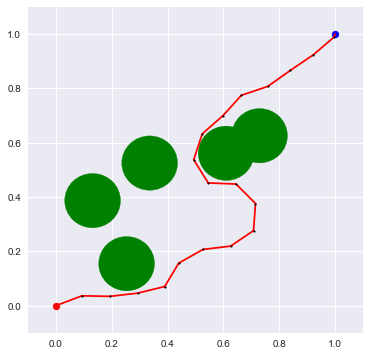

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.scatter(starting_point[0],starting_point[1],c="r")
plt.scatter(ending_point[0],ending_point[1],c="b")
for i in center:
    ax.add_artist(plt.Circle((i[0],i[1]),obstacle_size,color="g"))

rrt = RRT(starting_point,ending_point,step_size=0.1,velocity_constraint=True)
flag,p_archive = rrt.planning(1000,all_point=False)

print(flag)
# print(p_archive)
p_archive = np.array(p_archive)
ax.scatter(p_archive[1:-1,0],p_archive[1:-1,1],s=3,c="k",zorder=10);
for i in range(p_archive.shape[0]-1):
    plt.plot(p_archive[i:i+2,0],p_archive[i:i+2,1],c="r")
    

# Collect data of the "experienced task performer" from RRT

### run this block to save data for the CNN model

In [12]:
# observation_batch,action_batch =  rrt.output_observation_action(data_amount=1024*16,renew_center=True)
# print(observation_batch,action_batch*180/np.pi)
# np.save("observation_0411_16_1024_1st",observation_batch)
# np.save("action_0411_16_1024_1st",action_batch)

### run this block to save data for the CNN with LSTM model

In [13]:
# obs_act_4RNN =  rrt.output_observation_action_4RNN(round_amount=1024,renew_center=True)
# with open('act_obs_4RNN', 'wb') as f:
#     pickle.dump(obs_act_4RNN, f)

# Define and train the CNN model

In [20]:
class PlanningNet(nn.Module):
    def __init__(self):
        super(PlanningNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(3,6,5,1,2),
            nn.LeakyReLU(0.2),
            nn.MaxPool1d(kernel_size=2), 
        )
        self.conv2 = nn.Sequential( 
            nn.Conv1d(6,12,5,1,2),
            nn.LeakyReLU(0.2),
            nn.MaxPool1d(2),
        )
        self.conv3 = nn.Sequential( 
            nn.Conv1d(12,24,5,1,2),
            nn.LeakyReLU(0.2),
            nn.MaxPool1d(2),
        )
        self.linear1 = nn.Linear(9*24,64)
        self.linear2 = nn.Linear(64,16)
        self.linear3 = nn.Linear(18,7)

    def forward(self,input1,input2):
        x = input1
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0),-1)
        x = F.leaky_relu(self.linear1(x),negative_slope=0.2)
        x = F.leaky_relu(self.linear2(x),negative_slope=0.2)
        x = torch.cat((x,input2),dim=1)
        x = self.linear3(x)
        return x


### Load data

In [16]:
# Batch size = 1024, dimension of 1D array = 72
obs = np.load('data/observation_0411_16_1024_1st.npy') # shape (1024,148)
act = np.load('data/action_0411_16_1024_1st.npy') # shape (1024,)

### Split data into training and test data

In [14]:
train_obs, test_obs, train_act, test_act = train_test_split(obs, act, test_size=1/4)

### One-hot encode for train_act

In [15]:
def to_categorical(y):
    # returns one-hot encoded variable
    if (y<=math.pi/3 and y>math.pi*5/18):
        y=int(0)
    elif (y<=math.pi*5/18 and y>math.pi/6):
        y=int(1)
    elif (y<=math.pi/6 and y>math.pi/18):
        y=int(2)
    elif (y<=math.pi/18 and y>-math.pi/18):
        y=int(3)
    elif (y<=-math.pi/18 and y>-math.pi/6):
        y=int(4)
    elif (y<=-math.pi/6 and y>-math.pi*5/18):
        y=int(5)
    elif (y<=-math.pi*5/18):
        y=int(6)
    else:
        print("out of range!")
    return y

In [16]:
train_act_ = []
for i in range(len(train_act)):
    train_act_.append(to_categorical(train_act[i]))
train_act = np.array([train_act_]).reshape(-1,)

In [17]:
type(train_act[0]),train_act.shape

(numpy.int64, (12288,))

In [18]:
test_act_ = []
for i in range(len(test_act)):
    test_act_.append(to_categorical(test_act[i]))
test_act = np.array([test_act_]).reshape(-1,)

In [19]:
type(test_act[0]),test_act.shape

(numpy.int64, (4096,))

### Transform data into tensor set

In [20]:
train_obs = torch.Tensor(train_obs)
test_obs = torch.Tensor(test_obs)

In [21]:
train_act = torch.Tensor(train_act)
test_act = torch.Tensor(test_act)

In [22]:
train_data = Data.TensorDataset(train_obs,train_act) #(features, targets)
test_data = Data.TensorDataset(test_obs,test_act) #(features, targets)

In [23]:
train_loader = Data.DataLoader(dataset = train_data, batch_size = 768*16, shuffle = True, num_workers = 4)
test_loader = Data.DataLoader(dataset = test_data, batch_size = 256*16, shuffle = True, num_workers = 4)

### Compile the model

In [24]:
planning_net_CNN = PlanningNet()

In [25]:
optimizer_CNN = torch.optim.Adam(planning_net_CNN.parameters(),lr = 1e-3, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss()

### Train the model

In [26]:
training_loss = []
test_loss = []
test_accuracy = []
test_mse = []

In [27]:
for step,(inputs,label) in enumerate(train_loader):
    print(inputs.size())
    input1 = np.reshape(inputs[:,:216], [-1,3,72])
    input2 = np.reshape(inputs[:,216:], [-1,2])
    print(input1.size())
    print(input2.size())
    break

torch.Size([12288, 218])
torch.Size([12288, 3, 72])
torch.Size([12288, 2])


In [41]:
for epoch in tqdm(range(100)):
    
    # training set
    planning_net_CNN.train()
    for step,(inputs,label) in enumerate(train_loader):
        input1 = np.reshape(inputs[:,:216], [-1,3,72])
        input2 = np.reshape(inputs[:,216:], [-1,2])
        output = planning_net_CNN(input1, input2)
        label = torch.tensor(label, dtype=torch.long)
        loss = loss_func(output,label)
#         print("training loss = ",loss.item())
        training_loss.append(loss.item())
        optimizer_CNN.zero_grad()
        loss.backward()
        optimizer_CNN.step()
        
    # test set  
    planning_net_CNN.eval()   
    for step,(inputs,label) in enumerate(test_loader):
        input1 = np.reshape(inputs[:,:216], [-1,3,72])
        input2 = np.reshape(inputs[:,216:], [-1,2])
        output = planning_net_CNN(input1, input2)
        label = torch.tensor(label, dtype=torch.long)
        loss = loss_func(output,label)
        test_loss.append(loss.item())
        
        test_output = output
        pred_y = torch.max(test_output,1)[1]
        pred_y = pred_y.numpy()#.reshape(256,1)
        test_y = label.numpy()#.reshape(256,1)
        accuracy = float(sum(pred_y == test_y))/float(test_y.size)
        mse = np.sqrt(((pred_y-test_y)**2).mean())
        test_accuracy.append(accuracy)
        test_mse.append(mse)
        
        if epoch%10 == 0:
            print("test loss = ",loss.item())
            print("test mse = ",mse)
            print("test accuracy = ",accuracy,"\n\n")

/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


test loss =  1.3753180503845215
test mse =  1.2570115850699228
test accuracy =  0.408447265625 




/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test loss =  1.3731547594070435
test mse =  1.239999054939156
test accuracy =  0.413818359375 


test loss =  1.371267318725586
test mse =  1.2442249407261534
test accuracy =  0.40966796875 


test loss =  1.370137095451355
test mse =  1.2473604944541894
test accuracy =  0.411865234375 


test loss =  1.368739128112793
test mse =  1.2440287062101902
test accuracy =  0.413330078125 


test loss =  1.368499517440796
test mse =  1.2622447142887943
test accuracy =  0.408447265625 


test loss =  1.3660131692886353
test mse =  1.2453036778232047
test accuracy =  0.406982421875 


test loss =  1.3648850917816162
test mse =  1.2487298234105726
test accuracy =  0.406982421875 


test loss =  1.3639768362045288
test mse =  1.250292934425769
test accuracy =  0.40380859375 


test loss =  1.3631807565689087
test mse =  1.2575941192411804
test accuracy =  0.4072265625 





### Plot training curves

(0, 2.5)

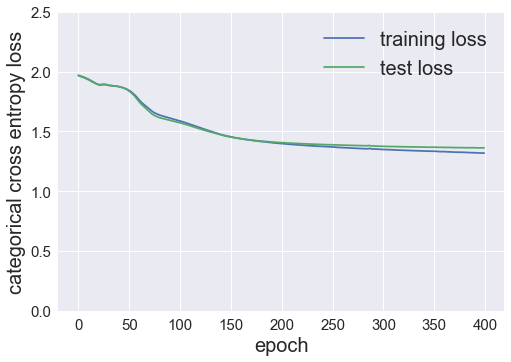

In [42]:
plt.plot(training_loss,label="training loss")
plt.plot(test_loss,label="test loss")
plt.legend(loc='best',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("epoch",fontsize=20)
plt.ylabel("categorical cross entropy loss",fontsize=20)
# plt.xlim(50,60)
plt.ylim(0,2.5)
# plt.ylim(1.4,1.5)

(0, 1)

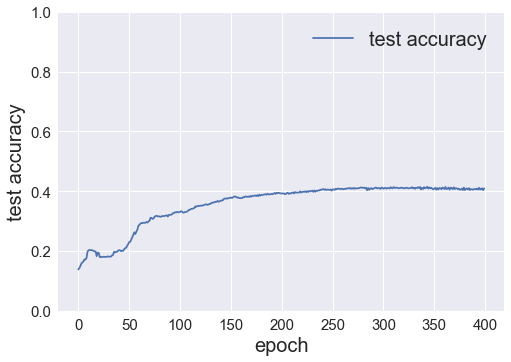

In [43]:
plt.plot(test_accuracy,label="test accuracy")
plt.legend(loc='best',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("epoch",fontsize=20)
plt.ylabel("test accuracy",fontsize=20)
plt.ylim(0,1)

(0, 2.5)

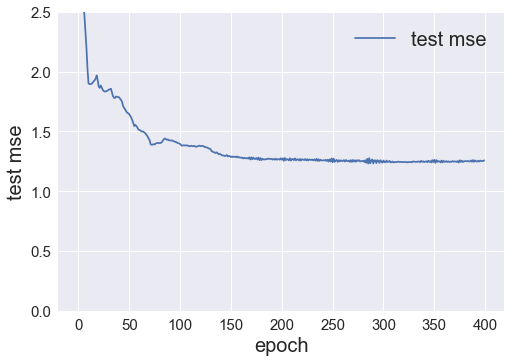

In [44]:
plt.plot(test_mse,label="test mse")
plt.legend(loc='best',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("epoch",fontsize=20)
plt.ylabel("test mse",fontsize=20)
plt.ylim(0,2.5)

### Save model

In [ ]:
# torch.save(planning_net_CNN,"/Users/ysgc/python_doc/AM216/Project/planning_net4")

# Define and train the CNN+RNN model

### Load data

In [17]:
with open('data/act_obs_4RNN', 'rb') as f:
    obs_act_4RNN = pickle.load(f)

### Split data into training and test data

In [46]:
training_index = np.random.choice(a=len(obs_act_4RNN),size=int(len(obs_act_4RNN)*3/4),replace=False)
training_set = []
test_set = []
for i in range(len(obs_act_4RNN)):
    if i in training_index:
        training_set.append(obs_act_4RNN[i])
    else:
        test_set.append(obs_act_4RNN[i])

### Define the model

In [19]:
class PlanningNet_withLSTM(nn.Module):
    def __init__(self):
        super(PlanningNet_withLSTM, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(3,6,5,1,2),
            nn.LeakyReLU(0.2),
            nn.MaxPool1d(kernel_size=2), 
        )
        self.conv2 = nn.Sequential( 
            nn.Conv1d(6,12,5,1,2),
            nn.LeakyReLU(0.2),
            nn.MaxPool1d(2),
        )
        self.conv3 = nn.Sequential( 
            nn.Conv1d(12,24,5,1,2),
            nn.LeakyReLU(0.2),
            nn.MaxPool1d(2),
        )
        self.lstm = nn.LSTM( # the raw nn.RNN seems to be more difficult to converge than LSTM
            input_size = 9*24,
            hidden_size = 64,
            num_layers = 1, # could be 2 or 3 or ...
            batch_first = True, # "True" for (batch_size,time_step,input), "False" for other cases
        )
        self.linear2 = nn.Linear(64,16)
        self.linear3 = nn.Linear(18,7)

    def forward(self,input1,input2,hidden=None):
        x = input1
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(1,x.size(0),-1)
        x,hidden = self.lstm(x,hidden) # do we need to add a activation function here???
        x = x.squeeze(0)
        x = F.leaky_relu(self.linear2(x),negative_slope=0.2)
        x = torch.cat((x,input2),dim=1)
        x = self.linear3(x)
        return x,hidden

### Compile the model

In [48]:
planning_net_LSTM = PlanningNet_withLSTM().float()

In [49]:
optimizer_LSTM = torch.optim.Adam(planning_net_LSTM.parameters(),lr = 1e-3, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss()

### Train the model

In [50]:
training_loss = []
test_loss = []
test_accuracy = []
test_mse = []

In [51]:
for epoch in tqdm(range(7)):
    
    # training
    planning_net_LSTM.train()
    training_loss_ = 0
    for (label,inputs) in training_set:
        hidden = None
        input1 = inputs[:,:216].view([-1,3,72])
        input2 = inputs[:,216:].view([-1,2])
        max_step = input1.size(0)
        outputs = []
        loss = 0
        for step in range(max_step):
            output,hidden = planning_net_LSTM(input1[step].unsqueeze(0).float(), \
                                         input2[step].unsqueeze(0).float(),hidden)
            loss += loss_func(output,label[step])
        loss = loss/max_step
        training_loss_ += loss
        optimizer_LSTM.zero_grad()
        loss.backward()
        optimizer_LSTM.step()
    training_loss.append(training_loss_/len(training_set))
    
    # testing
    planning_net_LSTM.eval()
    test_loss_ = 0
    accuracy_numerator = 0
    accuracy_denominator = 0
    for (label,inputs) in test_set:
        hidden = None
        input1 = inputs[:,:216].view([-1,3,72])
        input2 = inputs[:,216:].view([-1,2])
        max_step = input1.size(0)
        outputs = []
        loss = 0
        for step in range(max_step):
            output,hidden = planning_net_LSTM(input1[step].unsqueeze(0).float(), \
                                         input2[step].unsqueeze(0).float(),hidden)
            loss += loss_func(output,label[step])
            accuracy_denominator += 1
            test_y = label[step].numpy()
            pred_y = torch.max(output,1)[1].numpy()
#             print("test_y: ",test_y)
#             print("pred_y: ",pred_y)
            if pred_y == test_y:
                accuracy_numerator += 1
        loss = loss/max_step
        test_loss_ += loss

    test_loss.append(test_loss_/len(test_set))
    test_accuracy.append(accuracy_numerator/accuracy_denominator)

### Plot training curves

(0, 2.5)

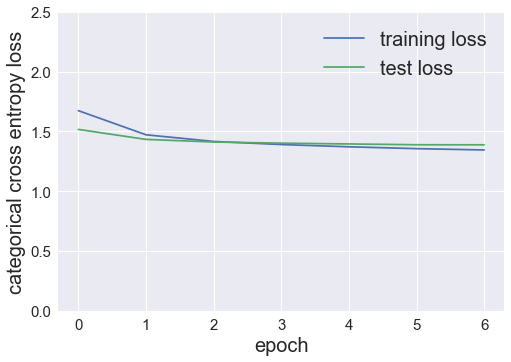

In [52]:
plt.plot(training_loss,label="training loss")
plt.plot(test_loss,label="test loss")
plt.legend(loc='best',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("epoch",fontsize=20)
plt.ylabel("categorical cross entropy loss",fontsize=20)
# plt.xlim(50,60)
plt.ylim(0,2.5)
# plt.ylim(1.4,1.5)

(0, 1)

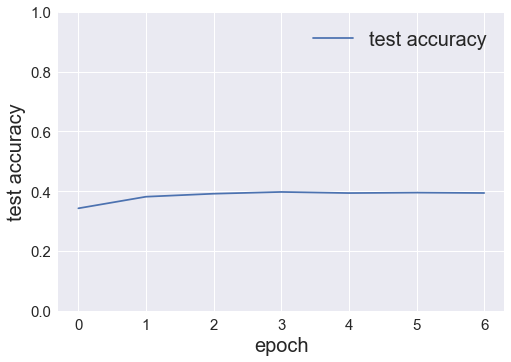

In [53]:
plt.plot(test_accuracy,label="test accuracy")
plt.legend(loc='best',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("epoch",fontsize=20)
plt.ylabel("test accuracy",fontsize=20)
plt.ylim(0,1)

# Training results analysis

* First, compared the model with LSTM to the model without LSTM, the training is much slower. Roughly on my Macbook, the training time for 1 epoch is 45s vs 1.5s.

* Secondly, LSTM costs much less epoches to converge: 3 epoches vs 400 epoches. 

* Thirdly, the training curves are more smooth in model with LSTM.

* Lastly, for both the model (with and without LSTM), the maximum prediction accuracy on test set is about 40%, which isn't a typically good result for a classification problem.

---

One hypothesis is that here's an one-to-many problem, showed in the following picture. In the right scenario, more than one choices are right answers, but in RRT, each time it can only choose one action.

<img src="visualization/one-to-many.png" width="400">

To compare the models' real performance, next we're going to change the criterion to *success rate* in a whole new environment. Actually, improving the success rate is the most essential goal for this project.

# Run neural network navigator in simulator

### Load pre-trained model

In [21]:
planning_net_CNN = torch.load("nn_model/planning_net4")
planning_net_LSTM = torch.load("nn_model/planning_net5")

In [29]:
# center = obstacle_generator(number=10,seed=17) # seed=int(time.time())-1
center = obstacle_generator(number=int(np.random.randint(5)+5),seed=9102)

### Define the neural navigator

In [16]:
class NeuralNavigator(Simulator):
    def __init__(self,center, neural_network,starting_point=np.array([0, 0]), 
                 ending_point=np.array([1, 1]),shape="circle",size=0.1):
        self.starting_point = starting_point
        self.ending_point = ending_point
        self.flag = False
        self.center = center
        self.neural_network = neural_network # import neural network model
        self.neural_network.eval() # set neural network to evaluation mode (no gradient calulation)
        self.map_from_number_to_angle = {0:np.pi/3, 1:np.pi/4.5, 2:np.pi/9, 3:float(0), \
                                         4:-np.pi/9, 5:-np.pi/4.5, 6:-np.pi/3}# actions from categories to radian values
        self.step_size = 0.025
        self.obstacle_size = size
        self.shape = shape

    def military_exercise(self, point=np.array([0.05, 0.05]), face_direction=
                          np.array([np.sqrt(2)/2, np.sqrt(2)/2]), plot="final",
                          temperature = 0.3,lstm=False):
        """
            TEST
            
            input: the testing point position, heading direction in np.array[(sine, cosine)] form,
                   the option for plotting, the temperature parameter in softmax layer
                   
            function: test the probability of each action choice given a point and a direction, and 
                      plot the results
                      
            output: a numpy array, shape = (1,7), in which the sum of every element = 1
        """
        input1,input2 = self.observe_148(point,face_direction,0)
        input1,input2 = torch.Tensor(input1),torch.Tensor(input2)
        print(input1.size(),input2.size())
        if lstm == False:
            output = self.neural_network(input1,input2)
        else:
            output,hidden = self.neural_network(input1,input2)
        if plot == "final":
            self.observe_with_lidar(point,face_direction,plot=True)
        return F.softmax(output/temperature).detach().numpy()

    def run_forrest_run(self, plot=True,face_direction=np.array([np.sqrt(2)/2, np.sqrt(2)/2]),\
                        max_step=150, probabilistic=False,step_size=0.05,temperature = 0.3,\
                        animation = False,lstm=False):
        """
            CORE
            
            input: the options for plotting, the temperature parameter in softmax layer, and other
                   settings.
                   
            function: in each iteration, run neural network to guide each moving step
                      
            output: a list of points in path, and a Bool value. True for success, and False for failure
        """
        point = self.starting_point
        self.p_archive = [point]
        self.step_size=step_size
        flag = False
        if lstm == True:
            hidden = None
        for count in tqdm(range(max_step)): # main iteration
            if self.end_or_not(point) == True: # determine if process ends or not
                flag = True
                break
                
            count += 1
            input1,input2 = self.observe_148(point,face_direction,count) # get the current observation
            input1,input2 = torch.Tensor(input1),torch.Tensor(input2)
            if lstm == False: # if the neural network doesn't include lstm
                output = self.neural_network(input1,input2)
            else: # if neural network includes lstm
                output,hidden = self.neural_network(input1.float(),input2.float(),hidden)
            output = F.softmax(output/temperature).detach().numpy().reshape(-1,)
            if probabilistic == False: # deterministic policy. Next action corresponds to max value of output.
                action = self.map_from_number_to_angle[int(np.argmax(output))]
            else:# stochastic policy. Next action's probability distribution is the output of a softmax layer.
                action = self.map_from_number_to_angle[int(np.random.choice(a=7,size=1,p=output))]
            absolute_angle = self.angle_combination(action,face_direction)
            face_direction = np.array([np.cos(absolute_angle),np.sin(absolute_angle)])
            point_next = point + face_direction*step_size
            self.p_archive.append(point_next)
            if animation == True: # save an animation for the whole path
                self.plot_path(self.p_archive,animation)
            if (self.collision_detect(point_next,point) == True or \
                    self.inside_region(point_next) == False):
                print("fail") # fail to finish the task
                break
            else:
                point = point_next
        if plot == True and animation == False:
            self.plot_path(self.p_archive,animation)
        return self.p_archive,flag
    
    def plot_path(self, path,animation):
        '''
            AUXILIARY
            
            input: path represented by a list of points, a Bool value for whether making a video or not
            
            function: visualize the path and environment. output an animation of the whole procedure.
            
            output: no output
        '''
        if animation == False:
            fig, ax = plt.subplots(figsize=(6, 6))
            plt.xlim(-0.1, 1.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(self.starting_point[0], self.starting_point[1], c="r")
            plt.scatter(self.ending_point[0], self.ending_point[1], c="b")
            if self.shape == "circle":
                size = self.obstacle_size
                for i in self.center:
                    # obstacle_size=0.1 by default
                    ax.add_artist(plt.Circle((i[0], i[1]), self.obstacle_size, color="g"))
            elif self.shape == "square":
                size = self.obstacle_size
                for i in self.center:
                    ax.add_artist(matplotlib.patches.Rectangle(i-np.array([size/2,size/2]),size,size, color='g'))
            path = np.array(path)
            ax.scatter(path[1:-1, 0], path[1:-1, 1], s=15, c="darkviolet", zorder=10)
            for i in range(path.shape[0]-1):
                plt.plot(path[i:i+2, 0], path[i:i+2, 1], c="k")
            plt.show()
        else:
            fig, (ax,ax2) = plt.subplots(figsize=(13, 6),ncols=2,nrows=1)
            ax.set_xlim(-0.1, 1.1)
            ax.set_ylim(-0.1, 1.1)
            ax.scatter(self.starting_point[0], self.starting_point[1], c="r")
            ax.scatter(self.ending_point[0], self.ending_point[1], c="b")
            if self.shape == "circle":
                size = self.obstacle_size
                for i in self.center:
                    # obstacle_size=0.1 by default
                    ax.add_artist(plt.Circle((i[0], i[1]), self.obstacle_size, color="g"))
            elif self.shape == "square":
                size = self.obstacle_size
                for i in self.center:
                    ax.add_artist(matplotlib.patches.Rectangle(i-np.array([size/2,size/2]),size,size, color='g'))
            path = np.array(path)
            ax.scatter(path[1:-1, 0], path[1:-1, 1], s=15, c="darkviolet", zorder=10)
            for i in range(path.shape[0]-1):
                ax.plot(path[i:i+2, 0], path[i:i+2, 1], c="k")
            self.observe_with_lidar(p1=path[-1],plot=True,ax=ax2)
            fig.savefig("/Users/ysgc/python_doc/AM216/Project/test_imgs/img"+\
                            str(len(path)-1).zfill(3)+".png")
        plt.close(fig)
        
    def end_or_not(self, point):
        '''
            AUXILIARY
            
            input: the current point position
            
            function: determine if a point can be regarded as destination
            
            output: a Bool value. True for termination, and False for not ending.
        '''
        if np.linalg.norm(point-self.ending_point) < 0.05 and \
                self.collision_detect(self.ending_point, point) == False:
            return True
        else:
            return False

### define two neural navigators with CNN and LSTM

In [17]:
center = obstacle_generator(number=int(np.random.randint(5)+5),seed=1102)

In [18]:
neural_navigator_CNN = NeuralNavigator(shape="circle", size=0.1,
                                   starting_point=np.array([0, 0]),
                                   ending_point=np.array([1,1]),
                                   neural_network=planning_net_CNN,
                                   center=center)
neural_navigator_LSTM = NeuralNavigator(shape="circle", size=0.1,
                                   starting_point=np.array([0, 0]),
                                   ending_point=np.array([1,1]),
                                   neural_network=planning_net_LSTM,
                                   center=center)

### Demonstrate the performance of neural navigators

torch.Size([1, 3, 72]) torch.Size([1, 2])


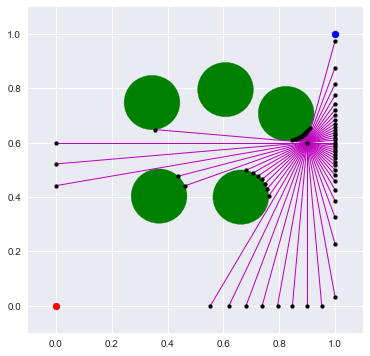

[[1.26982962e-12 8.48805939e-06 7.37787843e-01 1.44960180e-01
  1.17231555e-01 1.19707202e-05 3.74810778e-13]]
torch.Size([1, 3, 72]) torch.Size([1, 2])
[[1.0161848e-08 5.2915199e-04 5.2756608e-01 4.7165236e-01 2.5223830e-04
  5.3162996e-08 4.0502803e-11]]


/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [19]:
face_angle = np.pi/4
face_direction = np.array([np.cos(face_angle),np.sin(face_angle)])

print(neural_navigator_CNN.military_exercise(point=np.array([0.9,0.6]),\
                                            face_direction=face_direction,\
                                            lstm=False))
print(neural_navigator_LSTM.military_exercise(point=np.array([0.9,0.6]),\
                                            face_direction=face_direction,\
                                            plot=None,
                                            lstm=True))

/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


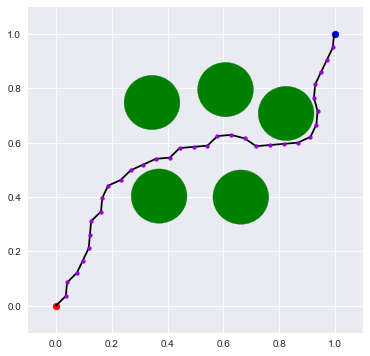

In [20]:
path = neural_navigator_CNN.run_forrest_run(probabilistic=True,temperature=0.1,plot=True,lstm=False)

/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


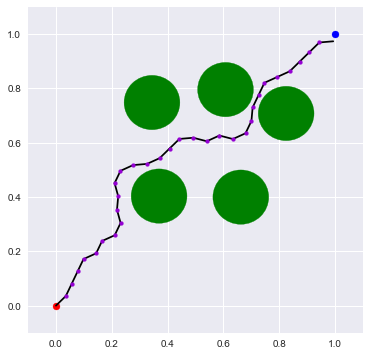

In [21]:
path = neural_navigator_LSTM.run_forrest_run(probabilistic=True,temperature=0.1,plot=True,lstm=True)

Here are two videos:

<img src="visualization/circ_demo.jpeg" width="600">

<img src="visualization/sqr_demo.jpeg" width="600">

### Evaluate the performance of neural navigators

In [22]:
def evaluate_navigator(obstacle_number=(5,5),obstacle_size=0.1,step_size=0.05,iteration=100,\
                       starting_point=np.array([0.0,0.0]),ending_point=np.array([1.0,1.0]),\
                       probabilistic=True,temperature = 0.3,plot=False,lstm=False):
    '''
        input: geometry parameters in the simulator, parameters for neural network decision making
        
        function: evaluate the performance of different neural networks in path planning
        
        output: success rate (successfully plan a path between starting and ending point)
    '''
    if lstm == True:
        planning_net = planning_net_LSTM
    else:
        planning_net = planning_net_CNN
    
    # test performance when obstacles are circle
    successful_num_circle = 0
    for i in tqdm(range(iteration)):
        center = obstacle_generator(number=int(np.random.randint(obstacle_number[0])\
                                              +obstacle_number[1]),seed=i+int(time.time()))
        neural_navigator = NeuralNavigator(shape="circle", size=obstacle_size,
                                           starting_point=starting_point,
                                           neural_network=planning_net,
                                           ending_point=ending_point, center=center)
        if neural_navigator.run_forrest_run(probabilistic=probabilistic,\
                                            temperature=temperature,plot=plot,\
                                            step_size=step_size,lstm=lstm)[1]:
            successful_num_circle += 1
    print(successful_num_circle/iteration)
    successful_num_square = 0
    
    # test performance when obstacles are square
    for i in tqdm(range(iteration)):
        center = obstacle_generator(number=int(np.random.randint(obstacle_number[0])\
                                              +obstacle_number[1]),seed=i+int(time.time()))
        neural_navigator = NeuralNavigator(shape="square", size=obstacle_size*1.77,
                                           starting_point=starting_point,
                                           neural_network=planning_net,
                                           ending_point=ending_point, center=center)
        if neural_navigator.run_forrest_run(probabilistic=probabilistic,\
                                            temperature=temperature,plot=plot,\
                                            step_size=step_size,lstm=lstm)[1]:
            successful_num_square += 1
    print(successful_num_square/iteration)
    
    # output
    return (successful_num_circle/iteration),(successful_num_square/iteration)

In [23]:
success_rate_CNN = evaluate_navigator(iteration=100,step_size=0.025,temperature=0.01,plot=False,lstm=False)

/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


fail


0.9


fail


fail


fail


0.7


In [46]:
success_rate_LSTM = evaluate_navigator(iteration=100,step_size=0.025,temperature=0.01,plot=False,lstm=True)

/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1.0


1.0


(1.0, 1.0)